# Consensus Peak Set

**Created**: 10 November 2021

## Environment

In [1]:
rm(list=ls())

if (!require("Rtsne")) {
    install.packages("Rtsne")
}

if (!require("UpSetR")) {
    install.packages("UpSetR")
}

Loading required package: Rtsne

Loading required package: UpSetR



In [2]:
library(tidyverse)
library(data.table)
library(RColorBrewer)
library(Rtsne)
library(UpSetR)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
consensus.peak.set <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/consensus_peaks.bed")
colnames(consensus.peak.set) <- c("Chr", "Start", "End", "Peak.Count", "Fold.Enrichment", "Log.10.P.Value", "Log.10.Q.Value", "Point.Source")

In [4]:
head(consensus.peak.set)

Chr,Start,End,Peak.Count,Fold.Enrichment,Log.10.P.Value,Log.10.Q.Value,Point.Source
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,23224,23849,18,"4.26835,3.20774,4.19841,3.9716,3.91778,3.14432,3.47702,3.09304,3.84191,3.68994,3.57102,3.52524,3.90613,3.46746,3.82138,2.79586,3.17876,3.78038","6.57404,4.13025,6.19201,5.57457,5.72838,4.2127,4.3671,3.77034,5.84526,4.69559,5.36996,5.06582,5.95644,4.5471,7.07514,3.61423,3.90426,5.26564","4.42707,2.08567,4.23675,3.63835,3.71803,2.35103,2.29233,1.68021,3.5372,2.83948,3.42845,3.07344,4.0007,2.53271,4.8448,1.91686,1.72493,2.95301","59,23,26,24,20,79,89,94,39,64,53,99,324,56,73,141,44,84"
1,24025,26778,94,"4.94474,4.0603,3.85645,4.355,3.47702,4.95791,2.82936,3.81901,3.87631,3.40492,2.94353,3.48865,3.08014,4.19248,4.15701,4.40021,3.20774,4.42679,4.43612,3.9878,3.30419,3.84571,4.43297,4.82383,3.31943,4.77276,4.94031,3.89417,4.06822,3.60755,4.00186,4.23835,3.85645,3.68685,3.17236,3.17629,3.19367,3.81901,3.30465,3.27971,3.62056,4.06822,3.07134,3.32645,3.98404,3.53196,3.91448,4.63602,3.54638,4.79283,3.34613,4.26362,5.10893,3.23946,4.50769,4.06871,3.9355,2.97219,3.08908,4.42679,4.97727,3.30518,3.90474,3.5913,5.38672,4.23835,4.65909,3.49523,2.93174,3.30465,3.32004,3.91448,3.49523,5.34978,4.64523,4.99787,3.98393,3.42916,3.60566,3.76287,3.84191,8.60985,4.01316,5.33363,4.30951,4.21154,4.0667,4.94474,4.37263,3.93504,4.50461,3.89417,4.04932,4.32256","8.00109,6.22119,5.16235,7.28448,4.3671,8.02308,4.00612,5.80549,5.90488,4.44726,3.87001,6.13277,4.10378,5.92828,7.20427,6.7953,4.13025,6.83971,7.13923,6.35515,4.89067,6.1008,7.42356,7.79844,4.50715,8.02044,7.11179,5.93578,5.49424,4.98376,6.38014,6.25743,5.16235,4.50892,4.26012,4.07937,4.29608,5.80549,4.10012,4.24636,5.69118,5.49424,4.27381,4.51887,5.83853,4.64978,5.48257,6.90256,5.10198,8.37,4.75696,6.56607,9.60553,3.83038,6.97445,5.2792,5.75789,4.45928,4.49527,6.83971,7.74636,4.48334,5.95404,4.95711,9.76066,6.25743,6.41714,4.79904,3.68011,4.10012,4.31121,5.48257,4.79904,10.4051,7.20222,8.08975,6.34825,4.68975,5.20308,5.70766,5.84526,16.9843,5.64135,8.32347,8.95822,5.95867,7.03343,8.00109,7.02973,6.26105,6.96933,5.93578,5.46468,5.67214","5.43666,3.87468,3.0124,5.35017,2.29233,5.30376,2.07469,3.74007,3.72492,2.55156,2.13092,4.13939,2.3486,3.90059,5.14816,4.59066,2.08567,4.61074,5.03088,4.13919,3.10647,4.09482,4.95824,5.81765,2.54444,5.7661,4.83579,3.71654,2.96196,2.92582,4.31618,3.8042,3.0124,2.31382,2.77784,2.23338,2.50772,3.74007,2.13927,2.06407,3.59042,2.96196,2.5433,2.59397,3.66413,2.35406,3.6247,4.6315,2.89767,6.02221,2.72946,4.18714,7.8062,1.82153,4.81992,3.24183,3.63266,2.47184,2.54427,4.61074,5.54806,2.61336,3.56617,3.00355,7.55915,3.8042,3.83422,2.71047,1.68484,2.13927,2.25258,3.6247,2.71047,8.38554,5.17376,5.98328,4.25497,2.81187,3.28611,3.83896,3.5372,14.7558,3.63146,6.28167,6.81178,3.84371,5.16063,5.43666,4.62867,4.33076,4.6157,3.71654,3.25641,3.23311","57,846,96,174,181,88,158,210,209,247,154,69,76,151,83,282,16,25,157,56,25,63,98,62,388,131,377,55,65,162,220,81,71,93,168,76,23,105,91,131,418,183,27,98,105,36,154,114,405,33,131,187,322,14,129,156,180,55,87,105,102,72,58,75,190,130,94,165,140,67,36,161,131,90,64,70,69,43,58,93,81,42,115,30,52,91,34,63,31,41,253,36,59,47"
1,28524,30136,184,"118.464,66.1243,180.831,50.2425,77.016,68.4209,87.1592,92.8843,108.536,182.568,63.5779,133.775,81.9138,78.0801,67.6926,75.3414,63.062,52.9569,236.481,170.845,80.056,101.789,107.855,97.5421,158.849,117.188,192.535,152.567,84.9737,185.623,74.7151,148.269,45.5503,30.0741,89.3626,73.927,202.579,59.2356,127.107,60.8675,77.9926,111.604,80.1311,77.824,141.718,87.7381,74.2087,191.181,69.5405,128.196,56.8557,44.7963,41.9712,125.253,89.9732,136.455,89.324,39.529,145.319,74.681,114.153,33.7797,143.217,49.8256,85.7873,85.806,78.7089,96.4364,67.1501,60.5785,36.6318,83.9821,61.7249,33.9368,91.5833,41.2317,29.6669,62.2921,32.4288,98.775,87.7997,30.5521,93.9821,69.8964,66.4863,24.831,108.285,45.2855,16.8711,93.175,64.0645,37.3392,35.3205,46.1134,36.7735,98.6454,120.368,13

In [5]:
peak.coverage <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/peak_coverage.tsv")

In [6]:
head(peak.coverage)

Chr,Start,End,SRR7650729,SRR7650730,SRR7650731,SRR7650732,SRR7650733,SRR7650734,SRR7650735,⋯,SRR7650915,SRR7650916,SRR7650917,SRR7650918,SRR7650919,SRR7650920,SRR7650921,SRR7650922,SRR7650923,SRR7650924
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,23224,23849,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,24025,26778,0,0,0,0,0,0,1,⋯,1,2,0,2,1,0,0,1,0,0
1,28524,30136,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,30354,30875,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
1,31109,31894,0,0,0,0,0,0,0,⋯,0,1,0,1,0,0,1,0,0,0
1,32151,32330,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_atac_seq.txt")
rownames(sample.info) <- sample.info$Run
sample.info <- sample.info %>%
    dplyr::select(Run, Donor, Cell.Type=Cell_type, Lineage=lineage, Treatment) %>%
    dplyr::mutate(Donor=factor(Donor), Cell.Type=factor(Cell.Type), Lineage=factor(Lineage)) %>%
    dplyr::mutate(Treatment=recode(Treatment, no_treament="No_Treatment", treatment1="Treatment_1", treatment2="Treatment_2"))

In [8]:
head(sample.info)

,Run,Donor,Cell.Type,Lineage,Treatment
,<chr>,<fct>,<fct>,<fct>,<chr>
SRR7650729,SRR7650729,1001,Bulk_B,B,No_Treatment
SRR7650730,SRR7650730,1001,Bulk_B,B,Treatment_1
SRR7650731,SRR7650731,1001,Mem_B,B,No_Treatment
SRR7650732,SRR7650732,1001,Mem_B,B,Treatment_1
SRR7650733,SRR7650733,1001,Naive_B,B,No_Treatment
SRR7650734,SRR7650734,1001,Naive_B,B,Treatment_1


In [9]:
chr.lengths <- read.table("~/gains_team282/epigenetics/star_genome_index/chrNameLength.txt")
colnames(chr.lengths) <- c("Chr", "Chr.Length")
rownames(chr.lengths) <- chr.lengths$Chr

In [10]:
head(chr.lengths)

,Chr,Chr.Length
,<chr>,<int>
1,1,248956422
10,10,133797422
11,11,135086622
12,12,133275309
13,13,114364328
14,14,107043718


## General Summary

There are $n=1344167$ peaks in the final set.

In [12]:
nrow(consensus.peak.set)

[1] 1344167

## Peaks per Chromosome

To see if there is a bias for certain chromosomes over other, I calculate the number of peaks per Mb of the chromosome. The data looks relatively consistent other than the Y chromosome, where few peaks were counted.

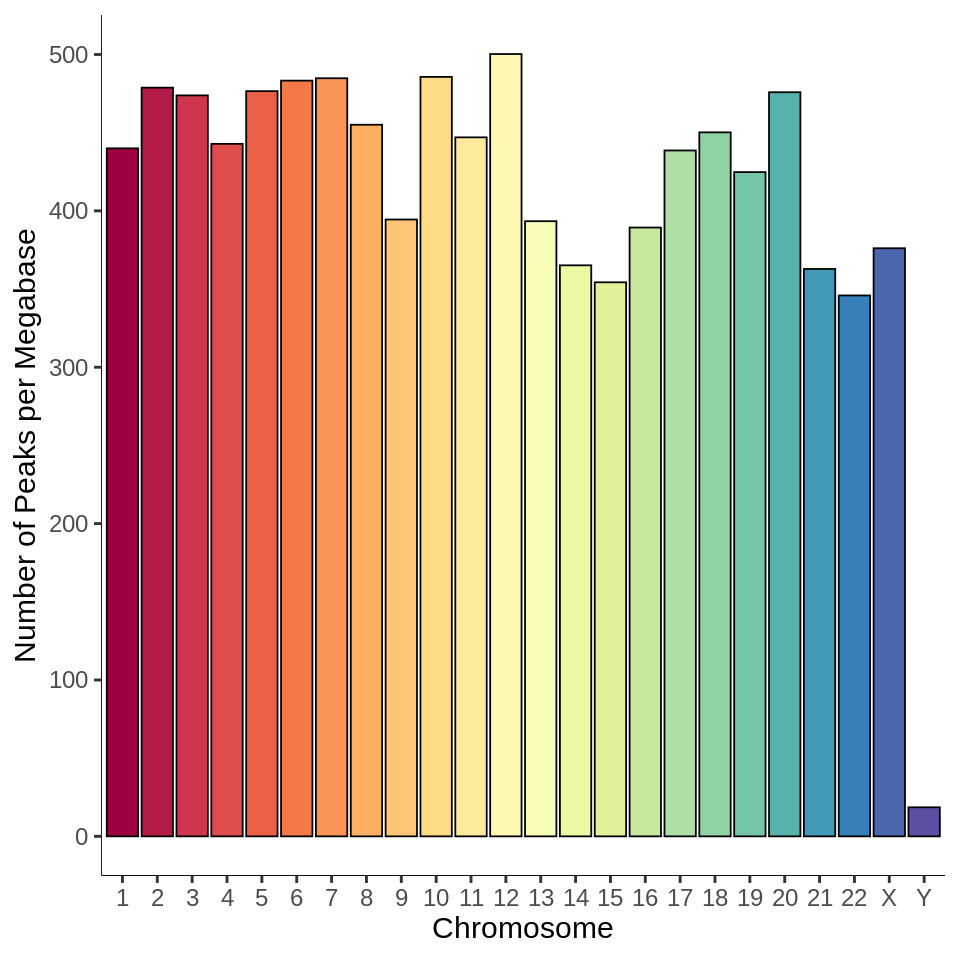

In [13]:
options(repr.plot.width=8, repr.plot.height=8)
consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::group_by(Chr) %>%
    dplyr::summarize(N.Peaks=n()) %>%
    dplyr::filter(Chr %in% c(1:22, "X", "Y")) %>%
    dplyr::mutate(Chr=factor(Chr, levels=c(1:22, "X", "Y"))) %>%
    merge(., chr.lengths, by="Chr") %>%
    dplyr::mutate(Normalized.N.Peaks=N.Peaks / Chr.Length * 10^6) %>%
    ggplot() +
    geom_bar(aes(x=Chr, y=Normalized.N.Peaks, fill=Chr), color="black", stat="identity") +
    scale_fill_manual(values=colorRampPalette(brewer.pal(11, "Spectral"))(24)) +
    xlab("Chromosome") + ylab("Number of Peaks per Megabase") +
    guides(fill="none") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_per_chromosome.svg", width=8, height=8)

## Peak Width

The peak size was restricted to below 3 kb. Any intersecting peaks that formed broad peaks (> 3 kb) should be pruned. The median peak size is 429. The distribution is skewed to the right, but in general the number of peaks approaching 3 kb is pretty small.

In [14]:
peak.width.data <- consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::mutate(Peak.Size=End-Start)
median(peak.width.data$Peak.Size)

[1] 429

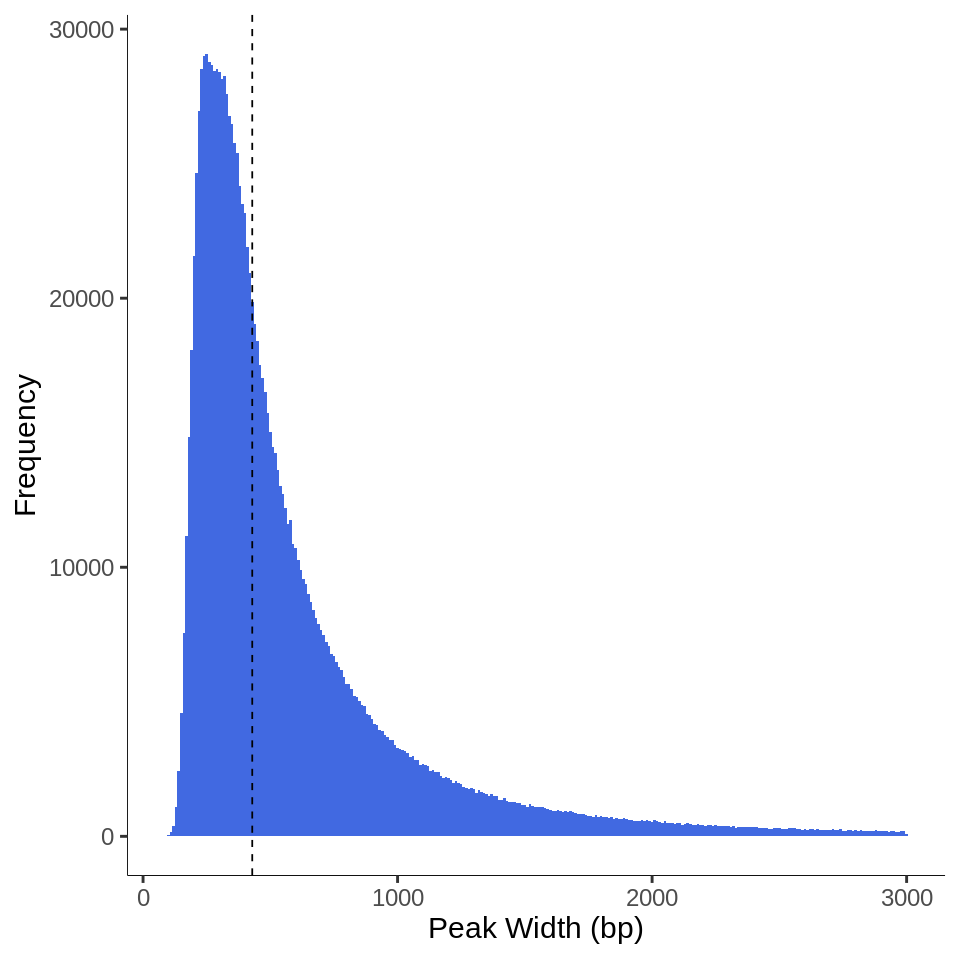

In [15]:
options(repr.plot.width=8, repr.plot.height=8)
peak.width.data %>%
    ggplot() +
    geom_histogram(aes(x=Peak.Size), binwidth=10, fill="royalblue") +
    geom_vline(xintercept=median(peak.width.data$Peak.Size), lty=2) +
    xlab("Peak Width (bp)") + ylab("Frequency") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_peak_width.svg", width=8, height=8)

## Counts of Peaks Merged

The median number of peaks being merged into a final peak in the consensus set is 4.

In [16]:
median(consensus.peak.set$Peak.Count)

[1] 4

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 5 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 5 rows containing missing values (geom_bar).”


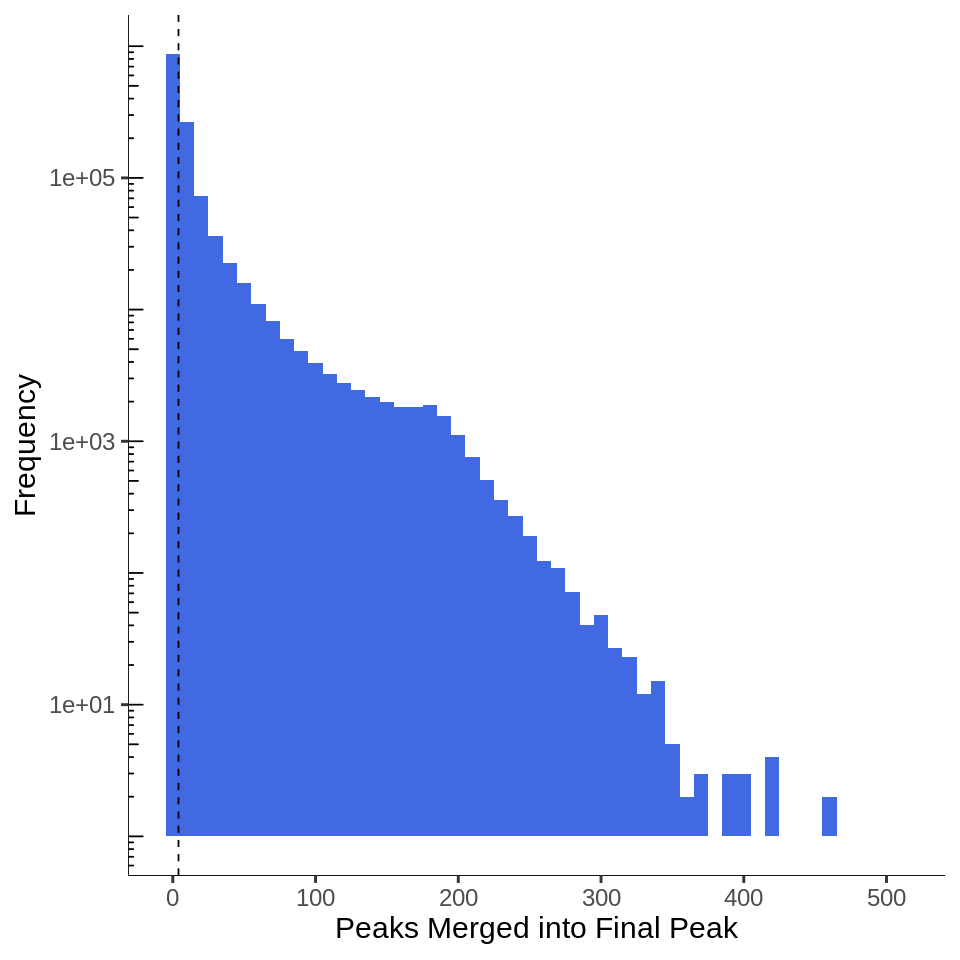

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
consensus.peak.set %>%
    as.data.frame() %>%
    ggplot() +
    geom_histogram(aes(x=Peak.Count), binwidth=10, fill="royalblue") +
    scale_y_log10() + annotation_logticks(base=10, sides="l") +
    geom_vline(xintercept=median(peak.width.data$Peak.Count), lty=2) +
    xlab("Peaks Merged into Final Peak") + ylab("Frequency") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_peak_count.svg", width=8, height=8)

It would be ideal if the number of peaks merging into the final peak does not increase the width of the peak. However, there is an association between final peak width and number of peaks merged to form the final peak.

There is an interesting repeating pattern when the count exceeds 175 (the number of ATAC peaks). By the pigeonhole principle, all these peaks merge at least two peaks from one sample. 

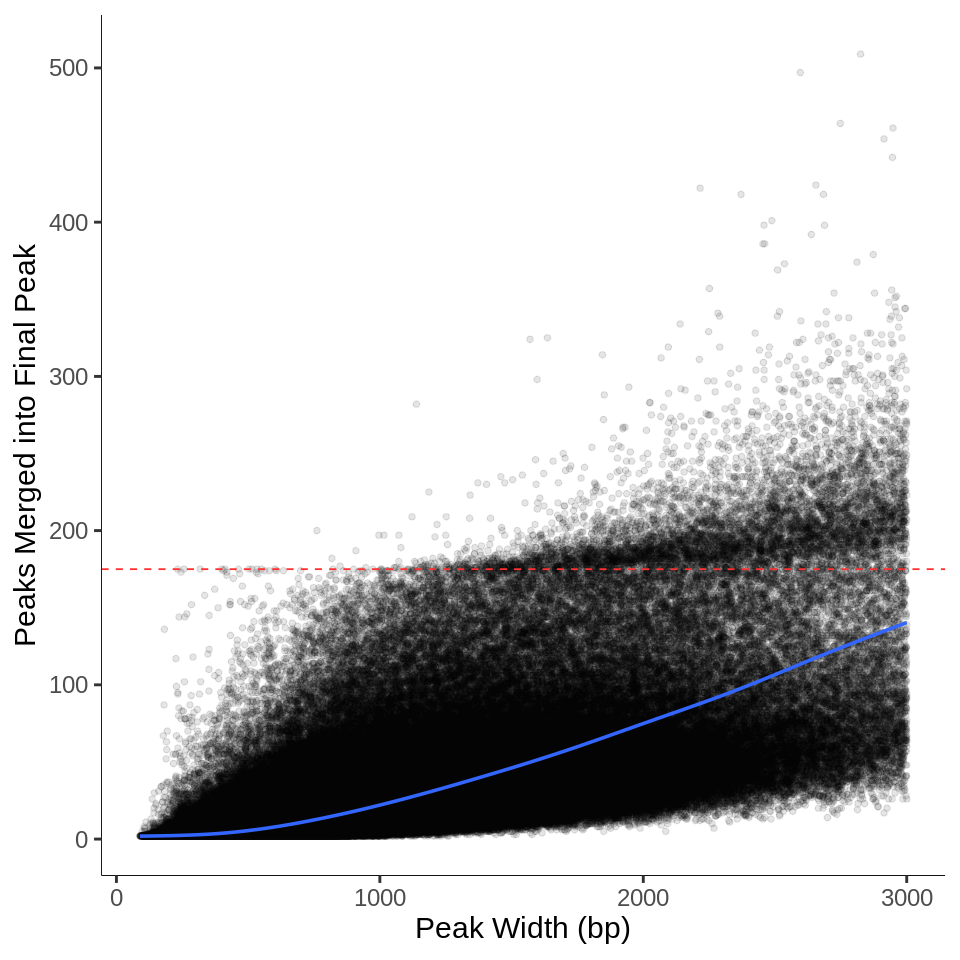

In [18]:
options(repr.plot.width=8, repr.plot.height=8)
consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::mutate(Peak.Size=End-Start) %>%
    ggplot(aes(x=Peak.Size, y=Peak.Count)) +
    geom_point(alpha=0.1) +
    geom_smooth(method="gam", formula=y~s(x + 0, bs="cs")) +
    geom_hline(yintercept=175, lty=2, color="firebrick1") +
    xlab("Peak Width (bp)") + ylab("Peaks Merged into Final Peak") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_peak_counts_by_width.png", width=8, height=8, dpi=600)

## Samples Contributing to Peaks

If the consensus peak set is merging peaks from too many samples into the final peaks, we will lose the power to distinguish between different cell types and treatments. Here, I check the distribution of the number of contributing samples to the final consensus peaks.

The median number of contributing samples is 4.

In [19]:
sample.cols <- setdiff(1:ncol(peak.coverage), 1:3)
peak.coverage[, Sums := apply(.SD, 1, function(x) sum(x > 0)), .SDcols = sample.cols]

In [20]:
median(peak.coverage[,Sums])

[1] 4

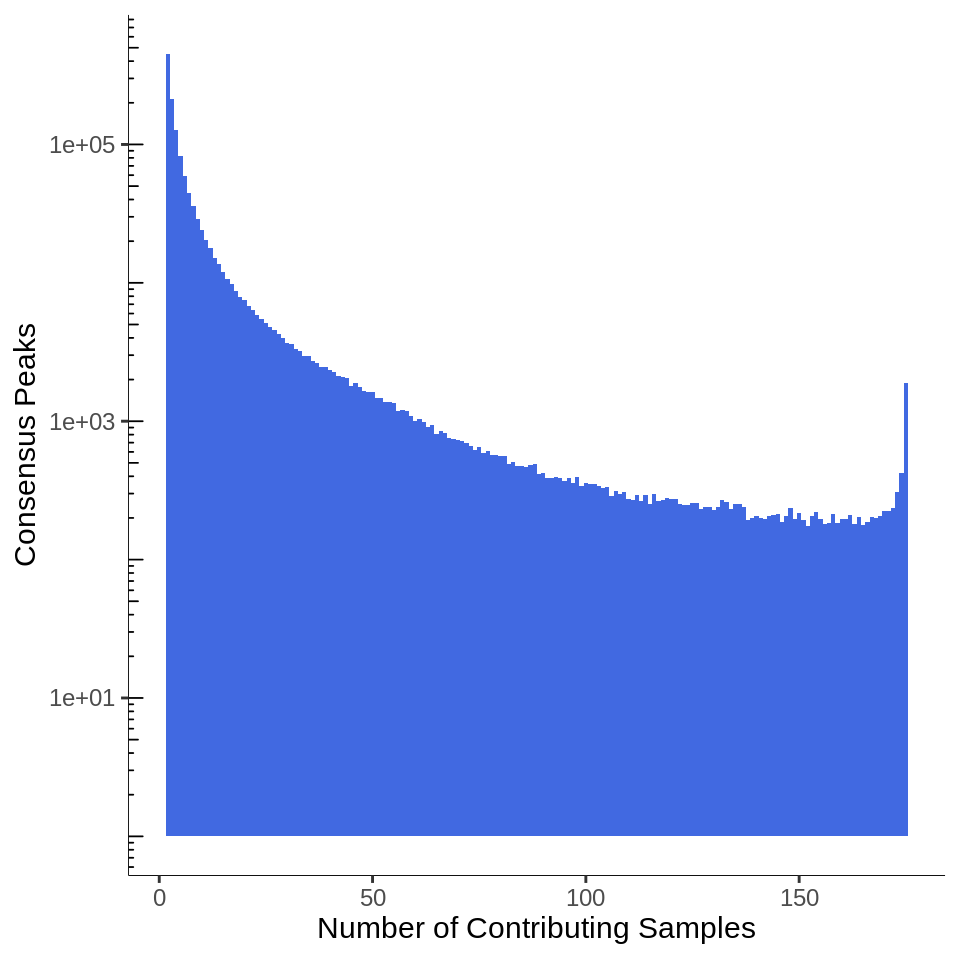

In [21]:
options(repr.plot.width=8, repr.plot.height=8)
peak.coverage[,Sums] %>%
    as.data.frame() %>%
    dplyr::select(N.Samples=1) %>%
    ggplot() +
    geom_histogram(aes(x=N.Samples), binwidth=1, fill="royalblue") +
    scale_y_log10() + annotation_logticks(base=10, sides="l") +
    xlab("Number of Contributing Samples") + ylab("Consensus Peaks") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_sample_coverage_per_peak.svg", width=8, height=8)

In [22]:
peak.coverage[, Sums := NULL]

## PCA on Peak Coverage

We can use the on/off status of samples at each consensus peak to profile each sample.

In [23]:
peak.coverage[, 4:178 := lapply(.SD, function(x) ifelse(x > 0, 1, 0)), .SDcols=4:178]

In [24]:
cols <- sample.info$Run[sample.info$Treatment == "No_Treatment"]
pca.res <- prcomp(as.matrix(transpose(peak.coverage[, ..cols])))

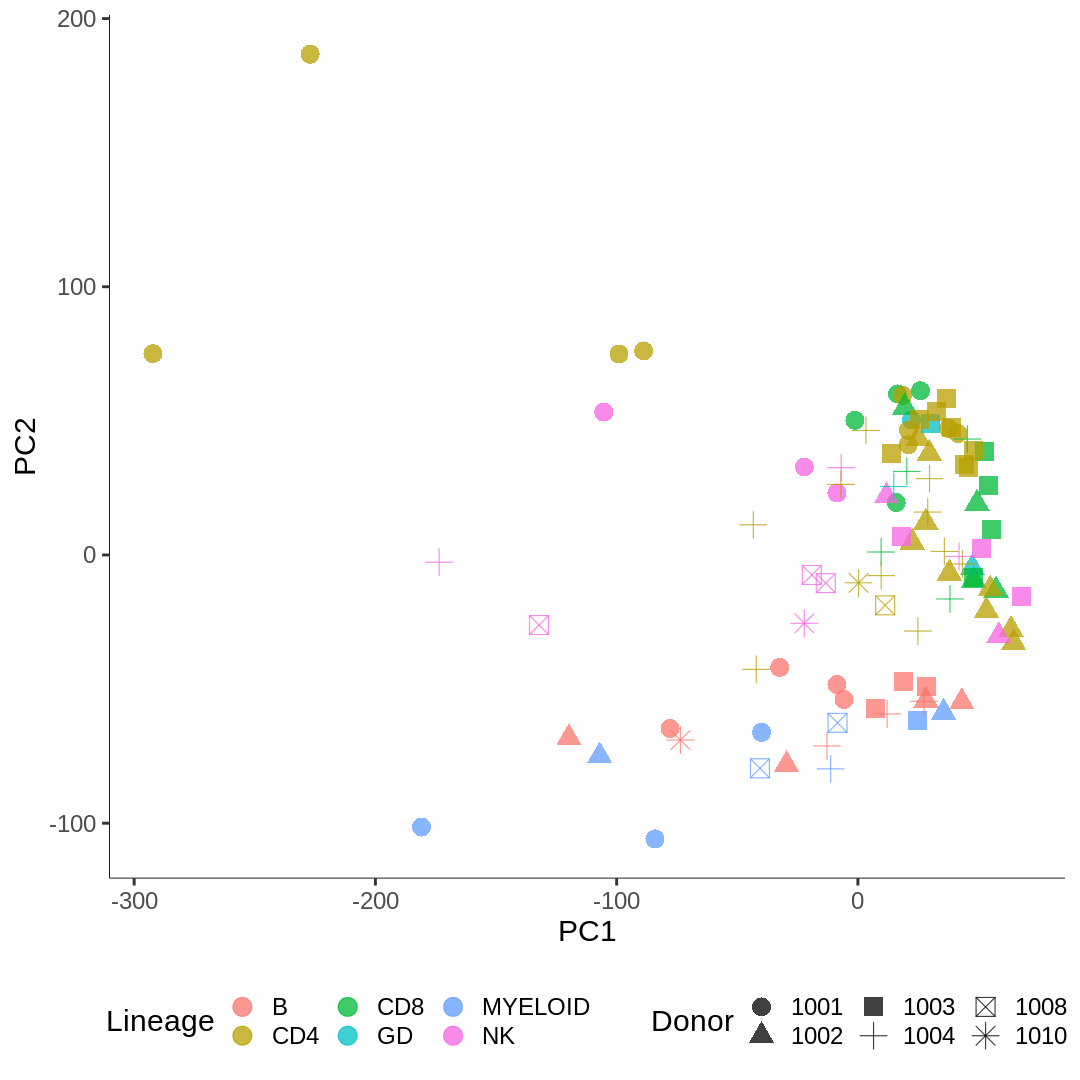

In [25]:
options(repr.plot.width=9, repr.plot.height=9)
pca.res$x %>%
    as.data.frame() %>%
    dplyr::mutate(Run=cols) %>%
    merge(., sample.info, by="Run") %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Lineage, shape=Donor), size=I(5), alpha=0.75) +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_coverage_pca.svg", width=9, height=9)

In [26]:
cols <- sample.info$Run[sample.info$Treatment == "No_Treatment"]
set.seed(13987395)
tsne.res <- Rtsne(as.matrix(transpose(peak.coverage[, ..cols])), theta=0.0, perplexity=5, num_threads=4)

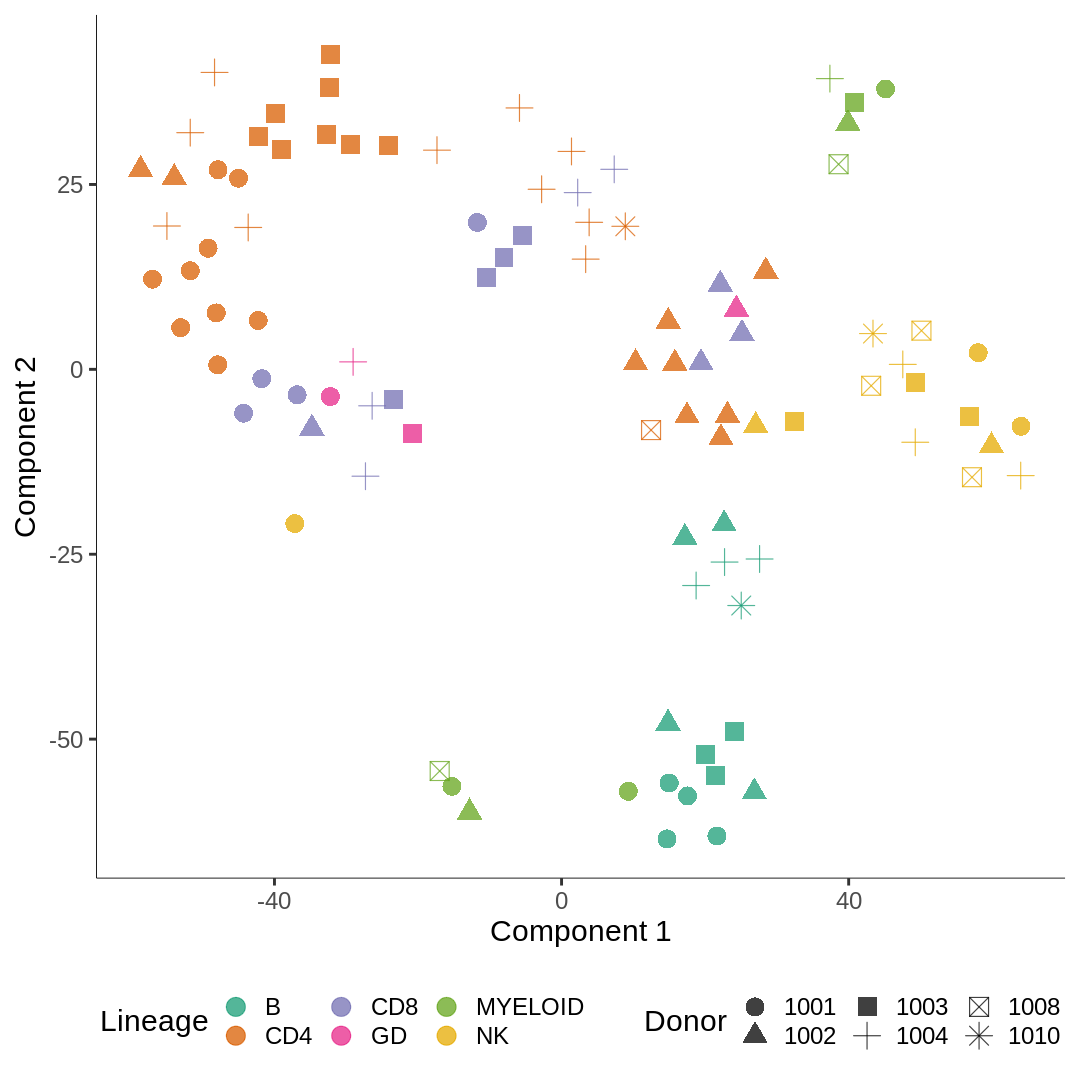

In [27]:
options(repr.plot.width=9, repr.plot.height=9)
tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp.1=1, Comp.2=2) %>%
    dplyr::mutate(Run=cols) %>%
    merge(., sample.info, by="Run") %>%
    ggplot() +
    geom_point(aes(x=Comp.1, y=Comp.2, color=Lineage, shape=Donor), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_coverage_tsne.svg", width=9, height=9)

## Condition-Specific Peaks

Since the consensus peak set is built using all samples whenever a peak is present in two or more samples, some peaks should be specific to certain conditions (treatment / donor / lineage / cell type).

### Donor-Specific Peaks in Consensus Set

In [28]:
# Calculate peaks from all samples for a given donor
donors <- unique(sample.info$Donor)
for (donor in donors) {
    cols <- sample.info$Run[sample.info$Donor==donor]
    peak.coverage[, paste0("Donor.", donor) := rowSums(.SD), .SDcols = cols]
}

donors.cols <- paste0("Donor.", donors)
donors.peak.coverage <- peak.coverage[,..donors.cols]

# Count the number of peaks where only one donor contributes to the consensus peak
donor.specific.peaks <- list()

for (donor.col in donors.cols) {

    donor.specific.peaks[[donor.col]] <- which(
        donors.peak.coverage[,..donor.col] > 0
    )
}

In [29]:
options(repr.plot.width=15, repr.plot.height=6)
svg("03_Functional_Interpretation/results/donor_specific_peaks.svg", width=15, height=6)
upset(fromList(donor.specific.peaks), nsets=length(donor.specific.peaks), nintersects=NA, show.numbers=F)
dev.off()

png 
  2

![Donor-Specific Peaks](../results/donor_specific_peaks.svg)

### Lineage-Specific Peaks in Consensus Set

In [30]:
# Calculate peaks from all samples for a given lineage
lineages <- unique(sample.info$Lineage)
for (lineage in lineages) {
    cols <- sample.info$Run[sample.info$Lineage==lineage]
    peak.coverage[, paste(lineage) := rowSums(.SD), .SDcols = cols]
}

lineages.peak.coverage <- peak.coverage[,..lineages]

# Count the number of peaks where only one lineage contributes to the consensus peak
lineage.specific.peaks <- list()

for (lineage in lineages) {

    lineage.specific.peaks[[lineage]] <- which(
        lineages.peak.coverage[,..lineage] > 0
    )
}

In [31]:
options(repr.plot.width=15, repr.plot.height=6)
svg("03_Functional_Interpretation/results/lineage_specific_peaks.svg", width=15, height=6)
upset(fromList(lineage.specific.peaks), nsets=length(lineage.specific.peaks), nintersects=NA, show.numbers=F)
dev.off()

png 
  2

![Lineage-Specific Peaks](../results/lineage_specific_peaks.svg)

### Peaks Specific to Biological Replicates in Consensus Set

In [32]:
biological.replicates <- sample.info %>%
    dplyr::group_by(Cell.Type, Treatment) %>%
    dplyr::summarize(Run=paste0("c(", paste0("\"", Run, "\"", collapse=","), ")"), Lineage=Lineage[1]) %>%
    dplyr::mutate(Name=paste0(Cell.Type, "_", Treatment))

`summarise()` has grouped output by 'Cell.Type'. You can override using the `.groups` argument.



In [33]:
# Calculate peaks from all samples for a given treatment
repl.names <- unique(biological.replicates$Name)
for (i in 1:nrow(biological.replicates)) {
    cols <- eval(parse(text=biological.replicates[i,"Run"]))
    peak.coverage[, paste(biological.replicates[i,"Name"]) := rowSums(.SD), .SDcols = cols]
}

repl.peak.coverage <- peak.coverage[,..repl.names]

In [34]:
repl.unique.peaks <- sapply(1:ncol(repl.peak.coverage), function(i) {
    neg.i = -i
    sum(repl.peak.coverage[,..i] > 0 & rowSums(repl.peak.coverage[,..neg.i]) == 0)
})

median(repl.unique.peaks)

[1] 59

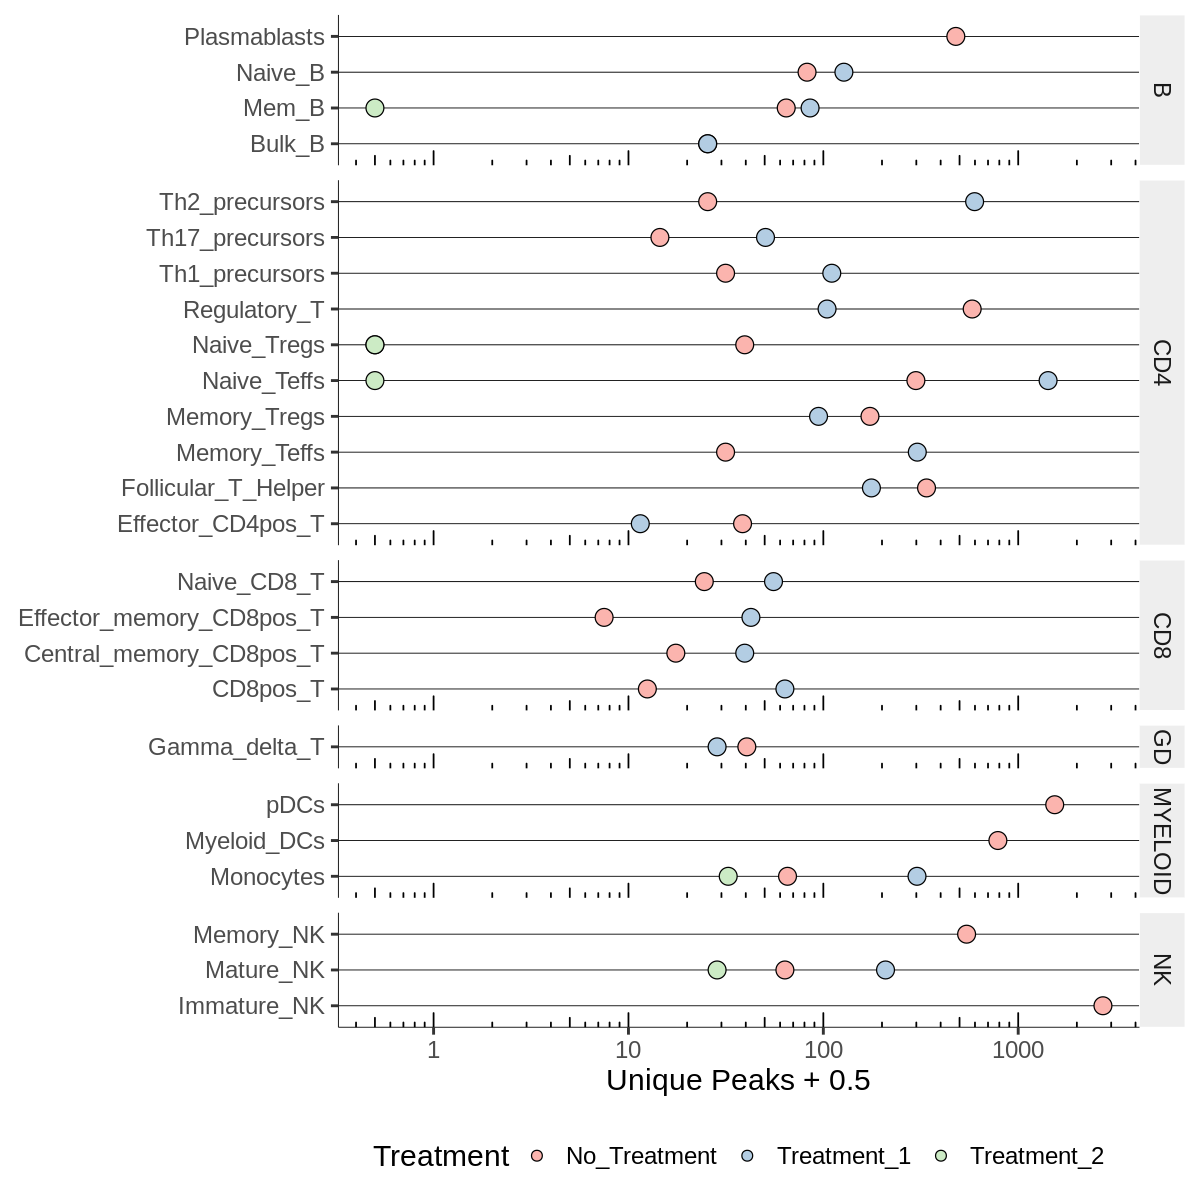

In [35]:
options(repr.plot.width=10, repr.plot.height=10)
biological.replicates %>%
    dplyr::ungroup() %>%
    dplyr::mutate(Unique.Peaks=repl.unique.peaks + 0.5) %>%
    ggplot(aes(x=Unique.Peaks, y=Cell.Type)) +
    geom_dotplot(aes(fill=Treatment), binaxis="y", stackdir="center", binwidth=0.5) +
    scale_x_log10() + annotation_logticks(base=10, sides="b") +
    scale_fill_brewer(palette="Pastel1") +
    facet_grid(Lineage~., scales="free", space="free") +
    xlab("Unique Peaks + 0.5") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), panel.grid.major.y=element_line(size=0.25))
ggsave("03_Functional_Interpretation/results/replicate_specific_peaks.svg", width=10, height=10)